# CSC8635 Machine Learning Extended Technical Report
## What is the need for the project?
<p>'Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small
size and lack of diversity of available datasets of dermatoscopic images.' (Tschandl, Rosendahl and Kittler, 2018). In this project, I will be exploring two machine learning models and running a comparison between them in order to choose the more suitable model for the project domain. As there is such 'a small size and lack of diversity' of datasets surrounding this area, the project will provide good groundwork for future projects to base off of.</p>

<p>'There are few comprehensive empirical studies comparing learning algorithms' (Caruana and Niculescu-Mizil, 2006). Machine learning comparisons are few and far between. In comparison with the small work put towards datsets in this domain, I believe that a comparison of machine learning technologies in this area would prove useful in automating skin cancer diagnosis with dermatoscopic images. 'I am using the paper 'An empirical comparison of supervised learning algorithms' as a basis for the comparison, and while the paper provides a much more detailed comparison than I am likely to need it still provides a solid background and good practises to follow for the comparison.</p>

## What did I do?
<p>In order to help achieve success in this project, a methodology was needed to follow a clear structure. KDD was decided as a suitable methodology for this project, as a large portion of the methodology is dedicated to data minining i.e. machine learning in this case.</p>

<p>Cookie Cutter was used to help structure the project in a reproducable format as well as providing ease of use for navigating around the directory. A cookie cutter build for data science was found that was excellent for the project at hand, and therefore used (Medium, 2019).</p>
<p>GitHub was used for version control and also allowed for backups in case of unforeseen errors.</p>

<p>Due to the limited time availible for the project and often massive runtimes of each model, only a two models were able to be compared. In this particular instance, I compared a custom built Convolutional Neural Network and a Virtual Geometry Group (VGG) pre-defined neural network (Simonyan and Zisserman, 2014). </p>

### Learning the Application Domain

<p>In order to understand the domain and the datasets of the project, I found it useful to read the paper from the developers of the dataset itself, 'The HAM10000dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions' (Tschandl, Rosendahl and Kittler, 2018).</p>

<p>While an artificial neural network was already built to differentiate between melanomas and melanocytic nevi, there was a lack of data for both of these cell types and others.</p>

<p>The original datasets used to generate the datasets for this project were discovered to have bias towards melanocytic lesions, which is explored in my own project when plotting the dataset in the 'Plotting the Data' section.</p>

<p>While there do exists multi-class predictions for skin diseases, at the time of writing the paper there were no models for dermatoscopic images, and at the time of writing the report there are very few working models of which the validity of the results is questionable. </p>

### Sources used to help produce code

<p>https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing</p>

<p>https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy?fbclid=IwAR2JWtc6_nC3PZwfg5THA1qjTx1qaLc6NllbXIAftRkZQu_AnQ6VMgaDsIs</p>

<p>https://engmrk.com/vgg16-implementation-using-keras/</p>

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras import applications
from sklearn.linear_model import LogisticRegression
from keras.layers import MaxPooling2D

Using TensorFlow backend.


In [2]:
# get working directory
cwd = os.getcwd()
print(cwd)

C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src


<p>Due to the nature of the document, it is not possible to associate every KDD step with the associated code, so some steps may be out of place but all relevant information is covered at some point in the report. I have aimed to include each step at the point where it was first used.</p>
<h3>Creating a Target Dataset</h3>
<p>As the dataset is quite large and the machine learning models can be very demanding in terms of resources, it is important that only relevant data was used. The metadata was used for the exploratory data analysis process, but ultimately only the images were used for the machine learning process itself. The source location</p>
<h3>Data Cleaning and Preprocessing</h3>
While it was initially thought that there would be a large amount of data cleaning and preprocessing, after accelerating past this step it was noticed that data cleaning was mostly unneccesary for the project, as explained later in the report. While it was useful to understand the dataset further, problems like this highlight the issues of KDD.

Relevant data cleaning is discussed later in the discussion for the models.

In [3]:
# change working directory to import data
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\data")

In [4]:
metadata_df = pd.read_csv("HAM10000_metadata.csv")

<p>Image paths were assigned to the metadata dataframe in order to provide a 'merge' and connect the data.</p>

In [5]:
# dictionary for image paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('*', '*.jpg'))}

In [6]:
# change working directory back
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src")

<p>A dictionary was produced for readability during the exploratory data analysis phase and general ease of use throughout the process.</p>

In [7]:
# dictionary to rename cell types for readability
lesion_type_dict = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-like Lesions ',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Bowens Disease',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

<p>Cells were assigned an ID to be used as a response variable later in the project.</p>

In [8]:
# add column for path of image
metadata_df['path'] = metadata_df['image_id'].map(imageid_path_dict.get)
# add column for cell types, for readability
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)
# assign each cell type an ID and add it to a column
metadata_df['cell_type_id'] = pd.Categorical(metadata_df['cell_type']).codes

<p>Some introductory exploratory data analysis was performed in order to get a feel and general understanding for the data. This included use of the head, tail, and columns functions.</p>

In [9]:
# print first 5 values of dataframe
print(metadata_df.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                      path                       cell_type  \
0  HAM10000_images_part_1\ISIC_0027419.jpg  Benign Keratosis-like Lesions    
1  HAM10000_images_part_1\ISIC_0025030.jpg  Benign Keratosis-like Lesions    
2  HAM10000_images_part_1\ISIC_0026769.jpg  Benign Keratosis-like Lesions    
3  HAM10000_images_part_1\ISIC_0025661.jpg  Benign Keratosis-like Lesions    
4  HAM10000_images_part_2\ISIC_0031633.jpg  Benign Keratosis-like Lesions    

   cell_type_id  
0             1  
1             1  
2             1  
3             1  
4             1  


In [10]:
# print first 5 values of dataframe
print(metadata_df.tail(5))

         lesion_id      image_id     dx dx_type   age     sex localization  \
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                          path       cell_type  cell_type_id  
10010  HAM10000_images_part_2\ISIC_0033084.jpg  Bowens Disease             2  
10011  HAM10000_images_part_2\ISIC_0033550.jpg  Bowens Disease             2  
10012  HAM10000_images_part_2\ISIC_0033536.jpg  Bowens Disease             2  
10013  HAM10000_images_part_2\ISIC_0032854.jpg  Bowens Disease             2  
10014  HAM10000_images_part_2\ISIC_0032258.jpg        Melanoma             5  


<p>This allows us to see the first and last 5 values of the metadata dataset, and get a general understanding of how the data is formatted.</p>

In [11]:
# print column names
print(metadata_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_id'],
      dtype='object')


In [ ]:
# print columns and their data type
print(metadata_df.dtypes)

In [12]:
# summary of numeric values
print(metadata_df.describe())

               age  cell_type_id
count  9958.000000  10015.000000
mean     51.863828      3.528208
std      16.968614      1.377071
min       0.000000      0.000000
25%      40.000000      4.000000
50%      50.000000      4.000000
75%      65.000000      4.000000
max      85.000000      6.000000


<p>While the mean age is calculated as 52, as the ages in the dataset are given in intervals of 5, this may not actually be a true representation of the ages. However, for our purposes with the dataset as long as the age is kept consistent throughout this is not a large issue, although in order to get a more precise model in a future project it may help to give the exact ages.</p>

<p>Despite images only being used for the final model, data cleaning was still used due to the methodologys structure and general good practise. While it was good practise, for my particular models these steps were irrelevant for training the models and optimising accuracy. The documentation for this data cleaning and commented code has been left in the report for reproducability. This also provides a basis for future work on the project if someone chose to include the meta data in their model, which may be beneficial for comparing image classification and extracting features from the image and classifying using the data.</p>

<p>For data cleaning, it is often important to deal with null/NA values from data to remove redundant rows from the dataset. In this situation, as age was the only column with null values I opted to replace them with the mean value of the age column. In order to improve accuracy further, it may be worthwhile in a future project to look at other factors that my affect age and calculate the age based of of that e.g. are certain ages more likely to have a certain cell type? While not null values, I removed any rows that had unknown values (prevalent in the sex and localization columns) to maximise information gain.</p>

In [13]:
# gives us data types and how many values of each column are non-null
print(metadata_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
path            10015 non-null object
cell_type       10015 non-null object
cell_type_id    10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB
None


In [14]:
# fill null values of age with the mean value of the age column
#metadata_df["age"] = metadata_df["age"].fillna(int(metadata_df["age"].mean()))

In [15]:
# display unique values in cell type column
print(metadata_df.dx.unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [16]:
# display unique values in diagnosis column
print(metadata_df.dx_type.unique())

['histo' 'consensus' 'confocal' 'follow_up']


In [17]:
# display unique values in sex column
print(metadata_df.sex.unique())

['male' 'female' 'unknown']


In [18]:
# drop rows where sex = unknown
metadata_df = metadata_df[metadata_df.sex!='unknown']

In [19]:
# display unique values in sex column
print(metadata_df.localization.unique())

['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


In [20]:
# drop rows where localization = unknown
metadata_df = metadata_df[metadata_df.localization!='unknown']

#### Plotting the Data

<p>Data was plotted to allow further exploration in the dataset as well as giving the oppurtunity to spot any patterns that the dataset may contain.</p>

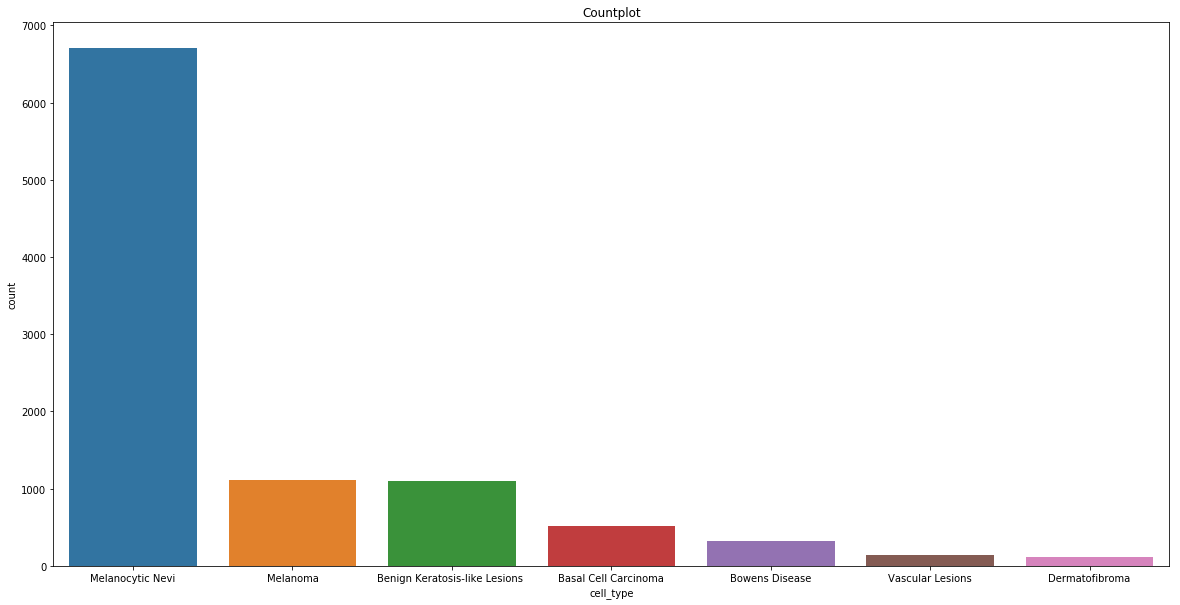

In [21]:
# countplot of cell type
plt.figure(figsize=(20, 10))

sns.countplot(x = 'cell_type',
              data = metadata_df,
              order = metadata_df['cell_type'].value_counts().index)
plt.title("Countplot")
plt.show()

In [22]:
metadata_df.groupby('cell_type').count()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type_id
cell_type,,,,,,,,,
Basal Cell Carcinoma,514,514,514,514,514,514,514,514,514
Benign Keratosis-like Lesions,1099,1099,1099,1099,1089,1099,1099,1099,1099
Bowens Disease,327,327,327,327,327,327,327,327,327
Dermatofibroma,115,115,115,115,115,115,115,115,115
Melanocytic Nevi,6705,6705,6705,6705,6660,6705,6705,6705,6705
Melanoma,1113,1113,1113,1113,1111,1113,1113,1113,1113
Vascular Lesions,142,142,142,142,142,142,142,142,142


<p>Here we can see that there are a much larger amount of Melanocytic Nevi cells than any other type, with approximately 6 times more values then the next most frequent cell, melanoma. The least frequent cell type is Dermatofibroma. This means that there is a huge range of 6384. This is important to consider for the machine learning models, as it may lead to overfitting. For example, if the model was incorrect and predicted every image as Melanocytic Nevi, it would result in a high accuracy for the training data but low accuracy for the test data. This also stresses the importance of using a confusion matrix, as it allows me to verify the validity of my results.</p>

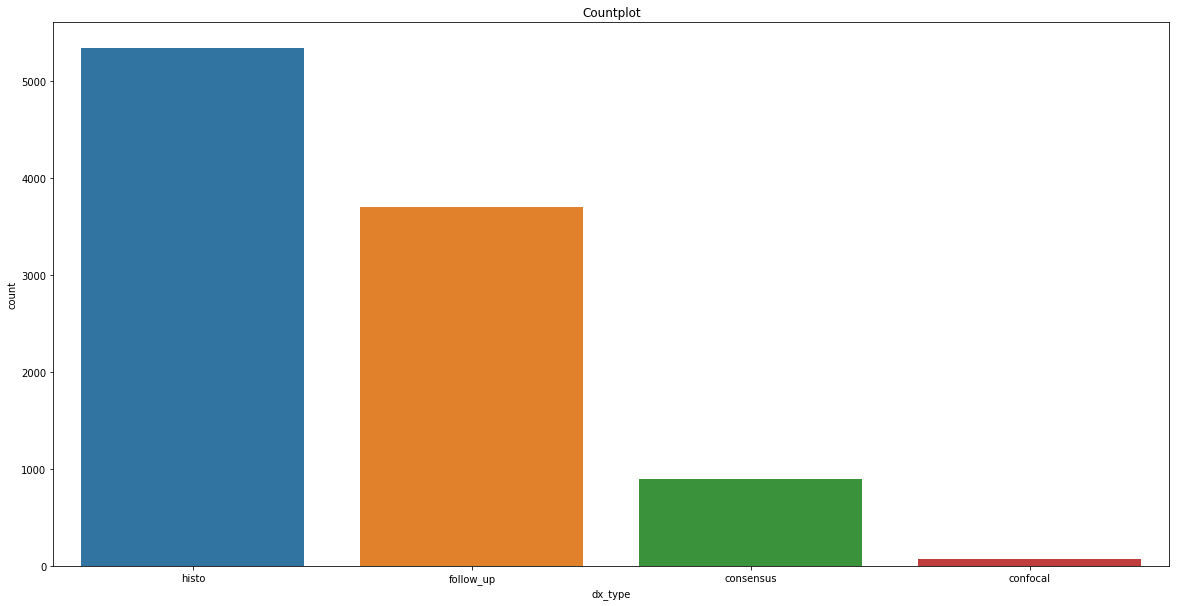

In [23]:
# countplot of diagnosis
plt.figure(figsize=(20, 10))

sns.countplot(x = 'dx_type',
              data = metadata_df,
              order = metadata_df['dx_type'].value_counts().index)
plt.title("Countplot")
plt.show()

<p>A countplot of the diagnosis type was produced, which allows us to see how the cells in the images were diagnosed. Although this will not necessarily affect our results, it is worth noting that this gives us some insights into how the cancer is diagnosed and potential false diagnoses.</p>

C:\Users\b5034806\AppData\Local\Continuum\anaconda3\envs\MLEnv3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\b5034806\AppData\Local\Continuum\anaconda3\envs\MLEnv3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


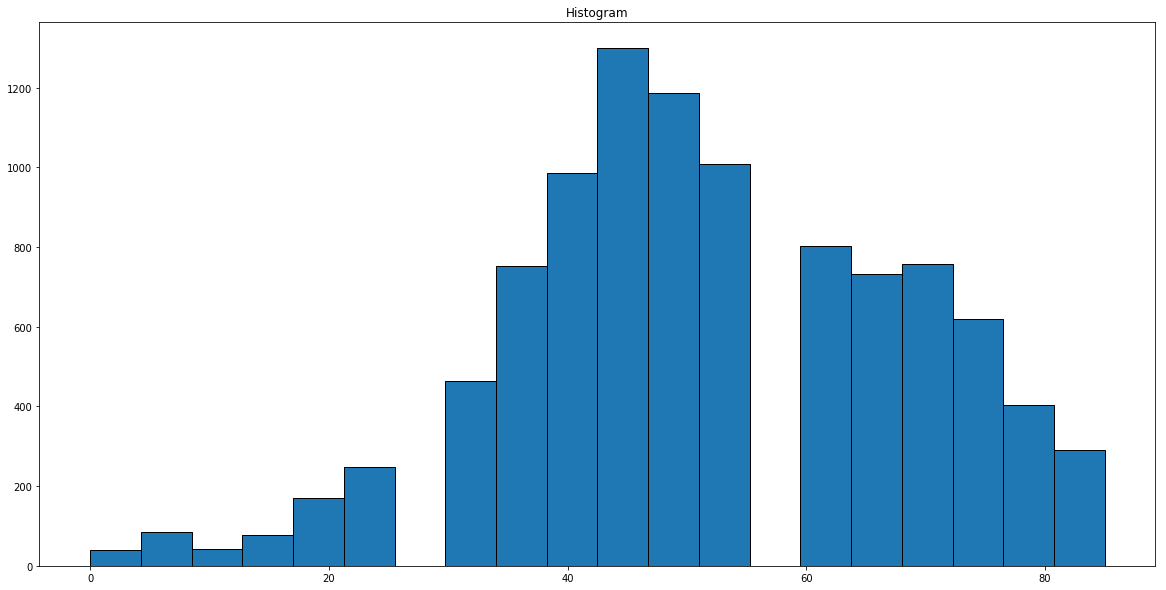

In [24]:
# histogram of age
plt.figure(figsize=(20, 10))

plt.hist(metadata_df['age'], bins = 20, histtype='bar', ec='black')
plt.title("Histogram")
plt.show()

<p>To see the age distribution of the dataset, a histogram was produced. As we can see, the majority of people are in the 40-60 range, with very few people under the age of 20 included in the dataset.</p>

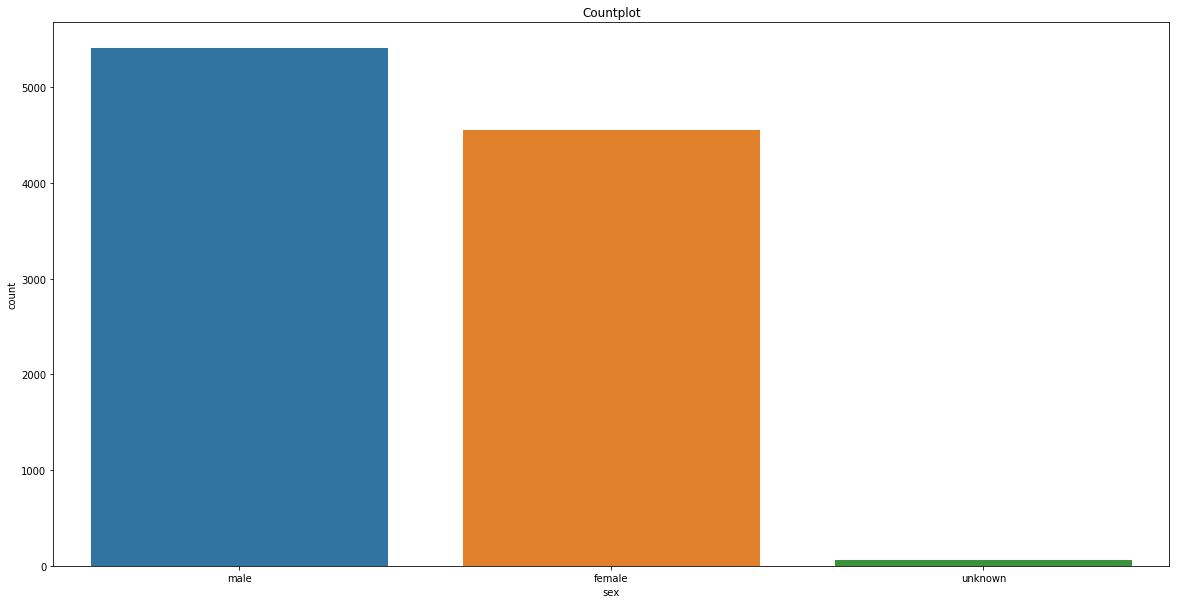

In [25]:
# countplot of sex
plt.figure(figsize=(20, 10))

sns.countplot(x = 'sex',
              data = metadata_df,
              order = metadata_df['sex'].value_counts().index)
plt.title("Countplot")
plt.show()

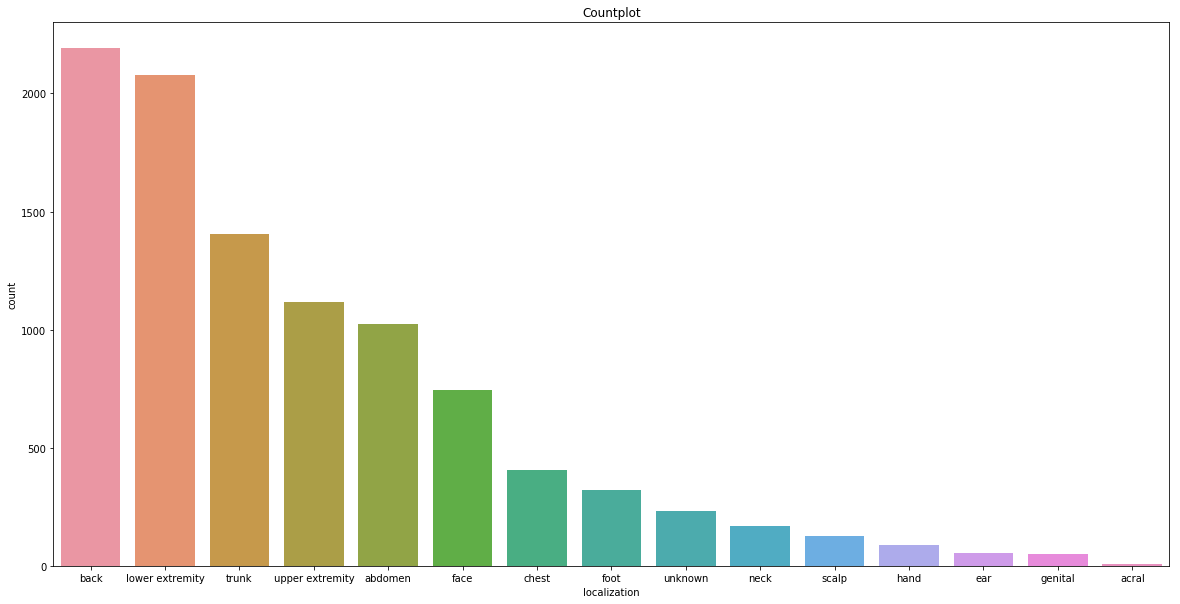

In [26]:
# countplot of loalization
plt.figure(figsize=(20, 10))

sns.countplot(x = 'localization',
              data = metadata_df,
              order = metadata_df['localization'].value_counts().index)
plt.title("Countplot")
plt.show()

### Data Reduction and Projection

<p>As neural networks are a natural choice for images and models excel without extracting the features, the metadata was not included for the final model and only the images were used. </p>

### Choosing Function of Data Mining

<p>Using the background reading, it was clear that this is a classification problem and that the models should predict the cell type, similarly to the old artificial neural network discussed in the 'Learning the application domain' section. The models will essentially be an expansion on that, with five more cell types.</p>

### Choosing the data mining algorithm

<p>I have decided that CNN and VGG will be a natural fit for this project, as they are both convolutional neural networks which are a natural solution for image classification, and it allows me to compare a custom built model with a pre-defined model.</p>

### Data mining

<p>The data mining process is discussed in depth throughout the discussion of the models:</p>

### Convolutional Neural Network
    
<p>CNNs are based upon neural networks in that they are based upon neurons. However, they differ from neural networks by taking in a multi chaneled image, which is suitable for our dataset as the images are RGB values which is read in as a 600x600x3 array, which equates to 3 chanels. CNNs are composed of convolutional, nonlinear, pooling and fully connected layers. The convolution layer works by convolving a filter around the image and computing element wise multiplications based upon the receptive field, which is summed up and repeated for each location on the image, which results in the feature map. This is how the model identified the features. The fully connected layer works by taking the high level features and associates these features with a class. In order to train a CNN, back propogation is used.</p>

<p>While all of the images are the same size and image resizing is not necessary, due to the timescale of the project it was essential for me to make the image sizes smaller to allow for faster run times, although this ultimately could affect the accuracy of the models due to a loss of data in the images. I have therefore tried to balance run time and accuracy, and resized the images to 1/3 of the original size. In the future, given a larger timescale/ better resources I would like to rexplore the dataset using the original image sizes and compare the accuracies and see if there is any significant differences between the original and rescaled images. While not directly applicable to our dataset, it is also important to note that padding is inefficient for classification problems, as it may cost some epochs for the neural network to calculate that there is no correlation in the black pixels using gradient descent (Howard, 2019).</p>

In [87]:
# change working directory for resizing
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\data")

metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# images scaled to 200x150, 1/3 of original size for CNN
#metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((200, 150))))

# change working directory back
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src")

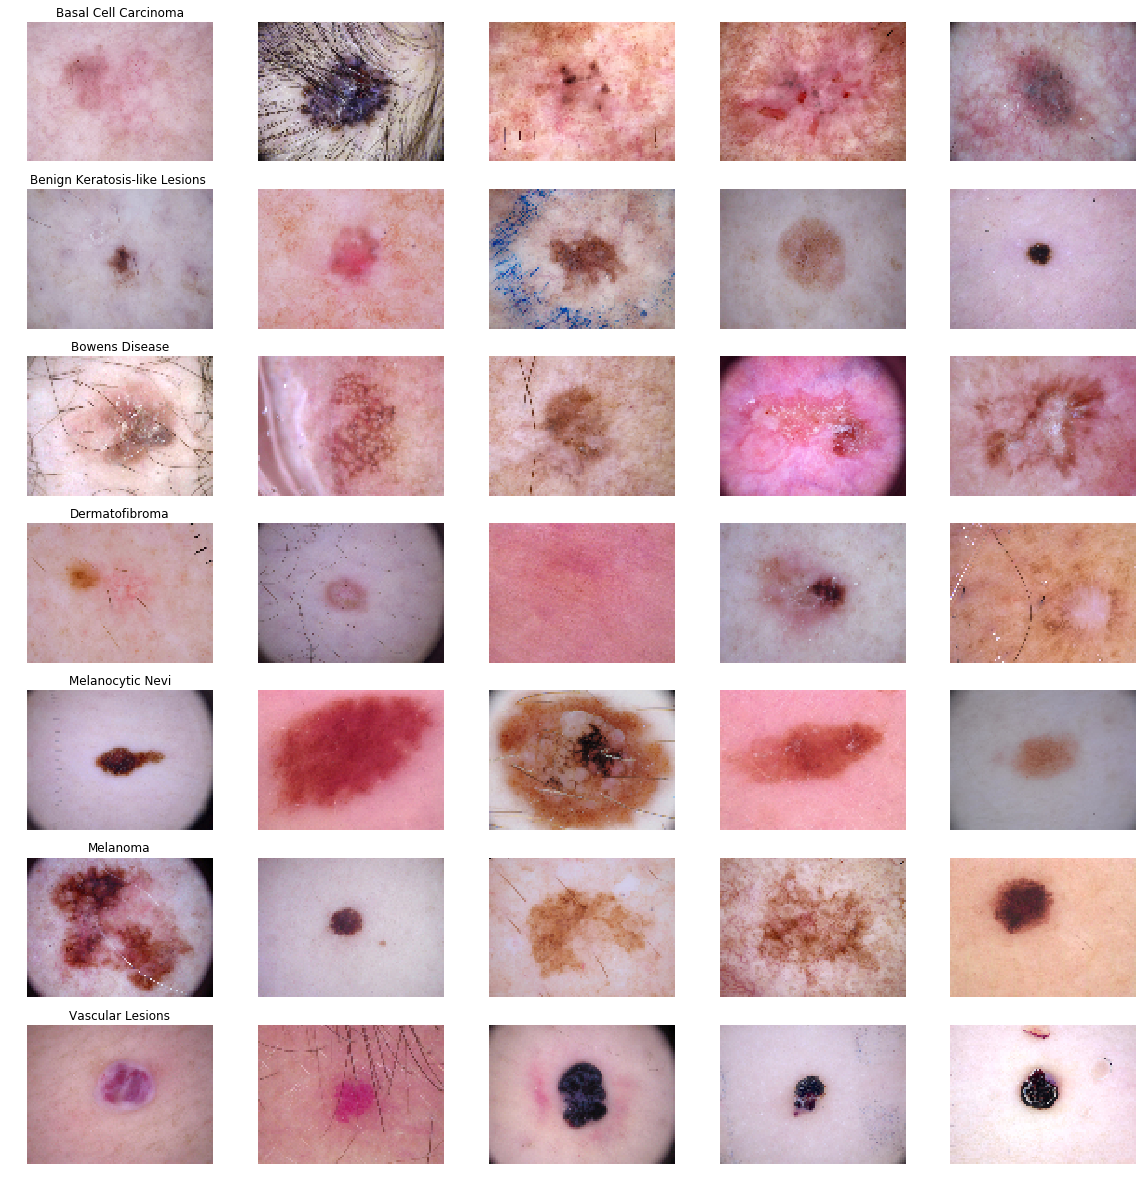

In [88]:
# thanks to https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing
# plot some of the images
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         metadata_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=66).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

<p>The predictor variables and response variable were split, so that the model would attempt to learn what cell type was in the image i.e. the image ID.</p>

In [89]:
# get predictor variables and add them to a dataframe
predictor = metadata_df.drop(columns=['cell_type_id'],axis=1)
# get response variables and add them to a series
response = metadata_df['cell_type_id']

<p>It was important to find a good balance between the training and test split, as a split too large will result in greater performance statistic variance, whereas a split too small will result in greater parameter estimate variance.</p>

In [90]:
# create training and test data for x and y variables at a 75:25 ratio
x_train, x_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=66)

<p>Data was normalised to get the values on a common scale, while also not distorting the differences in the range.</p>

In [91]:
# normalise data
x_train = np.asarray(x_train["image"].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train = (x_train - np.mean(x_train)) / (np.std(x_train))
x_test = (x_test - np.mean(x_test) / np.std(x_test))

In [92]:
# split data into training and validation data set at a 70:30 ratio
#x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.3, random_state = 66)

<p>One hot encoding was performed on the labels in order to allow the models to bypass the issue of categorical values.</p>

In [93]:
# one hot encoding
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

<p>A canal value of 3 was used for the convolutional layer, as previously explained in the 'Convolutional Neural Network' section.</p>

In [94]:
# canal value of 3 as images are RGB
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [95]:
# thanks to https://github.com/yuguan1/example-ML-code/blob/master/DL1/CNN.ipynb
# set the CNN model 
input_shape = (75, 100, 3)
nClasses = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(input_shape)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nClasses, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 98, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 49, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 23, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 17, 23, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25024)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3203200   
__________

<p>The adam optimiser is a generalised optimizer that works for many models, and is particularly efficient for deep learning.</p>

In [96]:
# compile the model

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])

<p>A learning rate annealer was used to stablise the learning rate. This was used as initially, the learning rate is too high which causes a high variance in accuracy and therefore divergant results. Stabilising the learning rate over time reduces the impact of this. It is also worth noting that having the learning rate too slow would require many epochs before reaching the minimum point on the gradient descent.</p>

In [97]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

<p>Data augmentation is used to prevent overfitting. As the dataset is not particularly large, data augmentation helps to prevent overfitting by generating relevant images with slight variations, to provide more data for the dataset and the variations help to encourage generalisation and therefore reduces the likelihood of overfitting.</p>

In [98]:
# data augmentation

datagen = ImageDataGenerator(
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

<p>'It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model...' (Keskar, Mudigere, Nocedal, Smelyanskiy and Tang, 2016). After reading this paper, it was clear that increasing the batch size too much would not be good, due to generalization. Too low of a batch size would result in a low accuracy and a slow computational process. It is also important to consider that there may be interactions with other hyperparameters. Therefore, epochs and batch sizes were experimented with to find the best balance between accuracy and speed.</p>

In [99]:
# train the model CNN RESULTS
epochs = 30 
batch_size = 16
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
469/469 [==============================] - 10s 22ms/step - loss: 0.9886 - acc: 0.6671 - val_loss: 8.4592 - val_acc: 0.3990s - loss: 1.1878 - - ETA:
Epoch 2/30
469/469 [==============================] - 10s 21ms/step - loss: 0.8769 - acc: 0.6903 - val_loss: 5.2785 - val_acc: 0.6725 ETA: 0s - loss: 0.8821 -  - ETA: 0s - loss: 0.8774 - acc: 0.
Epoch 3/30
469/469 [==============================] - 10s 21ms/step - loss: 0.8237 - acc: 0.7045 - val_loss: 5.1420 - val_acc: 0.5300
Epoch 4/30
469/469 [==============================] - 10s 21ms/step - loss: 0.7886 - acc: 0.7161 - val_loss: 5.5552 - val_acc: 0.5016
Epoch 5/30
469/469 [==============================] - 10s 21ms/step - loss: 0.7739 - acc: 0.7290 - val_loss: 5.2847 - val_acc: 0.6721

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
469/469 [==============================] - 10s 21ms/step - loss: 0.7217 - acc: 0.7357 - val_loss: 6.3815 - val_acc: 0.5915
Epoch 7/30
469/469 [=========

In [100]:
# thanks to https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

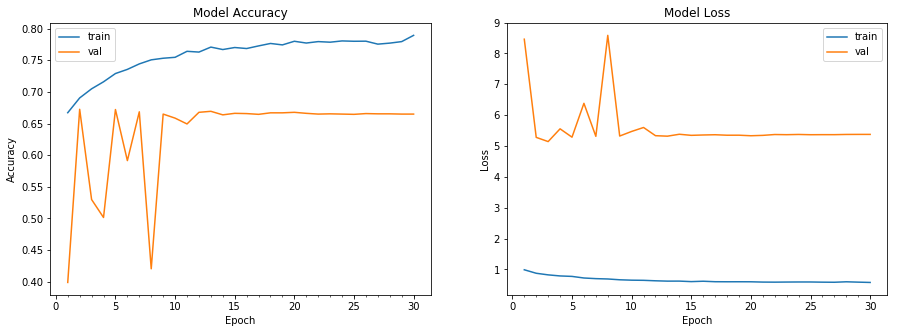

In [101]:
plot_model_history(history)

<p>From this plot we can immediately see how the learning rate annealer affects the model. Initially there are huge spikes in the accuracy for the test data, although after some epochs this stablises roughly at its peak (Approx 66%) due to the learning rate being reduced. This also applies to the test data's loss, which we can see stablises at the same Epoch as the accuracy. While the accuracy score is okay, the loss value is incredibly high and suggests that a lot of errors are being made every epoch, which may be due to the overfitting which will be explored with the next plot.</p>

NameError: name 'itertools' is not defined

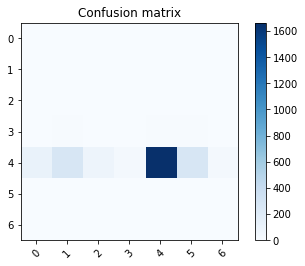

In [104]:
# thanks to https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test,axis = 1) 

confusion = confusion_matrix(y_pred, y_true)

# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion, classes = range(7))

<p>Unfortunately, the confusion matrix confirms that the model has been overfitted, as the model is only predicted for cell id 4, Melanocytic Nevi, which was previously discussed to potentially cause overfitting. As there is a significantly higher amount of Melanocytic Nevi than any other cell, the machine gets into the habit of only predicting these values, which likely explains the high loss experienced in the model.</p>

### VGG Neural Network

<p>The VGG Neural Network is a pre-defined neural network which was developed by 2 Oxford Students for a neural network competition, and received first place for image identification and 2nd place for image classification. It is popular for being a very efficient CNN and therefore in theory should perform better than the custom built CNN. </p>

In [27]:
# change working directory for resizing
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\data")

# images rescaled to 224x224 for VGG
metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

# change working directory back
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src")

In [28]:
# get predictor variables and add them to a dataframe
predictor = metadata_df.drop(columns=['cell_type_id'],axis=1)
# get response variables and add them to a series
response = metadata_df['cell_type_id']

In [29]:
# create training and test data for x and y variables at a 75:25 ratio
x_train, x_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=66)

In [30]:
# normalise data
x_train = np.asarray(x_train["image"].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train = (x_train - np.mean(x_train)) / (np.std(x_train))
x_test = (x_test - np.mean(x_test) / np.std(x_test))

In [31]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [32]:
# reshape images for VGG
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

In [33]:
# thanks to https://engmrk.com/vgg16-implementation-using-keras/
# set the VGG model
input_shape = (224, 224, 3)

model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
           activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(7, activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [34]:
# compile the model

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])

In [35]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [36]:
# data augmentation

datagen = ImageDataGenerator(
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [37]:
# train the model VGG RESULTS
# epochs reduced and batch size increased due to slow runtime
epochs = 20
batch_size = 32
history2 = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/20
234/234 [==============================] - 128s 546ms/step - loss: 5.3229 - acc: 0.6671 - val_loss: 5.2847 - val_acc: 0.6721
Epoch 2/20
234/234 [==============================] - 118s 506ms/step - loss: 5.3433 - acc: 0.6685 - val_loss: 5.2847 - val_acc: 0.6721
Epoch 3/20
234/234 [==============================] - 117s 501ms/step - loss: 5.3261 - acc: 0.6696 - val_loss: 5.2847 - val_acc: 0.6721
Epoch 4/20
234/234 [==============================] - 117s 502ms/step - loss: 5.3613 - acc: 0.6674 - val_loss: 5.2847 - val_acc: 0.6721

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
234/234 [==============================] - 117s 501ms/step - loss: 5.3179 - acc: 0.6701 - val_loss: 5.2847 - val_acc: 0.6721
Epoch 6/20
234/234 [==============================] - 118s 503ms/step - loss: 5.3665 - acc: 0.6670 - val_loss: 5.2847 - val_acc: 0.6721
Epoch 7/20
234/234 [==============================] - 117s 501ms/step - loss: 5.3214 - acc: 0.6698 - va

In [39]:
# thanks to https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

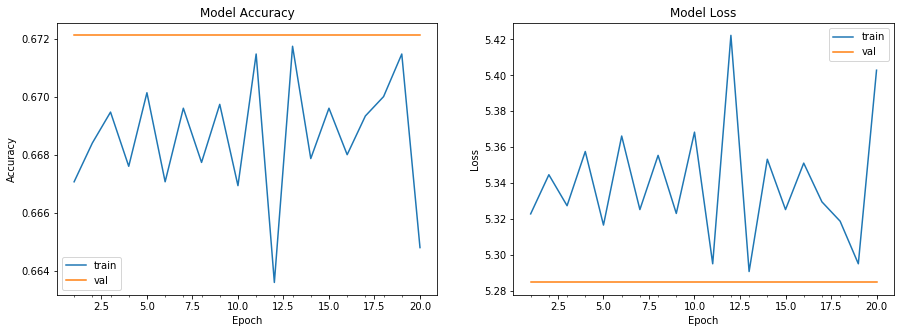

In [41]:
plot_model_history(history2)

<p>Even though VGG was not successful in working with the test data, we are still able to perform an analysis on the training data. Despite providing data annealing, the variation is high throughout every epoch suggesting that the learning rate was still too high, and data annealing needed to be applied more aggressively. On the other hand, you can actually see that the variance is only for a very small range and in reality the learning rate may not have been high enough to begin with. Even though the accuracy lies at a respectable 67.21%, as the validation accuracy and loss are flat it is likely that the model does not work as intended and the model is not actually learning anything about the images over time. This could potentially be explained to a very low training rate, and is something to keep in consideration for future implementation of VGG for this dataset. Due to VGG being quite demanding in terms of resources and taking large amounts of time each time the model is trained it was not possible to tune the parameters in many ways and try to 'fix' the model. This is something that can be explored in future projects.</p>

NameError: name 'itertools' is not defined

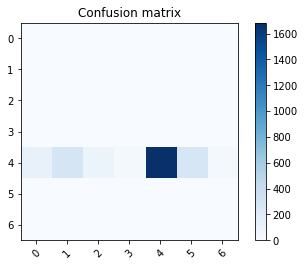

In [42]:
# thanks to https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test,axis = 1) 

confusion = confusion_matrix(y_pred, y_true)

# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion, classes = range(7))

<p>The confusion matrix for VGG is very similar to that of the custom built CNN, and also suggests that the model is overfitted, potentially giving an explanation for the results that were gathered. </p>

### Interpretation

<p>While it is likely that the results are not accurate, a comparison will still be made with the assumption that the results are 'correct'. Only the test data is compared, as training data results are not very relevant for comparisons between models. While the custom built CNN ends with an accuracy of 66.49%, VGG ends with the slightly higher accuracy of 67.21%. Similarly, the custom built CNN ends with a loss of 5.3748, whereas VGG ends with a loss of 5.2847. Taking both of these into account, VGG has the highest accuracy and lowest loss by a small margin, making it slightly better than the custom built model. It is also worth noting that it was significantly slower to train VGG than the custom built CNN, and so if the dataset is large enough it may be worth the tradeoff for a small amount of optimisation in loss and accuracy to get much faster run times.  However, to reiterate, it is likely that the models are not working as intended and these results should be treated cautiously.</p>

## How Successful was my Project?

<p>While a conclusion was met that satisfied the initial goal, the project may be deemed as unsuccesful as the models are likely not functioning as intended. However, I would argue that the project has seen success in many ways. For example, the groundwork has been layed out for anyone to pick up the project, add in a model of their choosing that they would like to compare, fine-tune the hyperparameters and use the tools provided such as the graphs for the models and confusion matrices for a comparison between any model. Another example would be that I have not yet discovered an attempt for an implementation of VGG on this dataset, and therefore the groundwork has also been layed out for the projects code to be tuned in such a way that VGG may receive more desireable results.</p>

<p>If using 'The Logical Framework Method for Defining Project Success' (Baccarini, 1999), the project can be deemed a failure in terms of 'project management success' as the original 'deliverable' was not achieved as desired. However, the project success can be deemed as a success as groundwork has been provided for future work in this area and although it was not the original deliverable, a successful output has been produce. The paper also makes a very good point about success not being 'black or white' and it may be more suitable to deem this project as a partial success.</p>

<p>In the future, I believe that a large scale comparison is needed, as if the 'most efficient' model is found, it could potentially be used in place of diagnosing by eye providing automated and fast diagnoses for dermatoscopic images.</p>

## Reflection

<p>This project also introduced me to many new technologies, which has been a pleasure. As this was my first large project with python, it was nice to learn a new programming language and the strengths and weaknesses that it comes with. Python was a very successful language for machine learning as it is widely supported and relatively simple to pick up, key for the short time scale of the project.  As a Data Scientist, I believe that both Python and R will prove to be useful tools to use in future projects as they excel in many tasks that are required of data science projects. Anaconda was a great way to produce environments for the project and easily download and manage the packages required for the code. Jupyter Notebooks was a great tool for producing markdown documents such as this one, and provides numerous advantages and disadvantages over R, such as code being much easier to manage in my opinion, but also a lot more tedious to use with the natural implementation of cells for programming. Cookie cutter lacks the automation that Project Template provides, although it adds a lot more customisation in that there are a huge amount of premade directories online, which allowed me to find the data science cookie cutter build which worked well for this project.</p>

<p>KDD was much more successful for this project than the cloud computing project, as it utilised all of the steps (cloud computing did not make use of the three data mining steps). However, that is not to say that it did not come without issues. As previously mentioned, the linearity of KDD can result in wasted time, or if followed precisely with no going back between steps can actually force a project to stop before starting another 'cycle' after the interpretation phase.</p>

<p>Ironically, the most straightforward part was likely implementing the models themselves (Although not to much success), as there are many existing frameworks that you can base yours off of. The most difficult part of the project for me was editing the models and data in a way such that accuracy and loss are optimised. When given a large dataset such as this one computation times can be quite slow which does not give many attempts at fine tuning the models.</p>

<p>For future projects, it is always worth following a methodology as it provides a natural work flow and clear objectives to achieve your goal, although I would like to explore a new methodology in my next project such as AGILE or SCRUM. It may also be worth considering my strengths/weaknesses for future projects, as while I attempted to tackle a quite difficult dataset in domains I have never worked with before (Medical and images for machine learning) which definitely improved my skills and abilities, it also led to the original goal not being met. Therefore, rather than taking on a whole new area at once, it may be wise to approach a project with more caution.</p>

# References

<p>Tschandl, P., Rosendahl, C. and Kittler, H. (2018). The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Scientific Data, 5, p.180161.</p>

<p>Howard, J. (2019). fast.ai · Making neural nets uncool again. [online] Fast.ai. Available at: https://www.fast.ai/ [Accessed 22 Jan. 2019].</p>

<p>Keskar, N.S., Mudigere, D., Nocedal, J., Smelyanskiy, M. and Tang, P.T.P., 2016. On large-batch training for deep learning: Generalization gap and sharp minima. arXiv preprint arXiv:1609.04836.</p>

<p>Caruana, R. and Niculescu-Mizil, A. (2006). An empirical comparison of supervised learning algorithms. Proceedings of the 

<p>23rd international conference on Machine learning - ICML '06.</p>
Simonyan, K. and Zisserman, A., 2014. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.</p>

<p>Medium. (2019). The best explanation of Convolutional Neural Networks on the Internet!. [online] Available at: https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8 [Accessed 23 Jan. 2019].</p>

<p>Medium. (2019). Cookiecutter Data Science — Organize your Projects — Atom and Jupyter. [online] Available at: https://medium.com/@rrfd/cookiecutter-data-science-organize-your-projects-atom-and-jupyter-2be7862f487e [Accessed 7 Jan. 2019].
</p>

<p>Deshpande, A. (2019). A Beginner's Guide To Understanding Convolutional Neural Networks. [online] Adeshpande3.github.io. Available at: https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/ [Accessed 24 Jan. 2019].</p>

<p>Baccarini, D. (1999). The Logical Framework Method for Defining Project Success. Project Management Journal, 30(4), pp.25-32.</p>